In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv
from skimage.segmentation import slic
from skimage.util import img_as_float
from torch_geometric.data import Data, DataLoader
import random
from sklearn.model_selection import train_test_split
from torch_geometric.nn import global_mean_pool

In [10]:
# Function to convert an image into a graph
def image_to_graph(img_path, label):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not load image {img_path}")
        return None
    
    img = cv2.resize(img, (224, 224))
    img = img_as_float(img)
    
    try:
        segments = slic(img, n_segments=100, compactness=10)  # Reduced segments for less overfitting
        
        nodes = np.unique(segments)
        features = []
        
        for node in nodes:
            mask = segments == node
            if np.sum(mask) > 0:  # Ensure the segment has pixels
                mean_color = np.mean(img[mask], axis=0)
                # Add more features to enrich representation
                std_color = np.std(img[mask], axis=0)
                features.append(np.concatenate([mean_color, std_color]))
        
        features = np.array(features)
        
        # Create spatial edge connections
        edges = []
        # Connect neighboring segments instead of fully connected graph
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                if are_segments_adjacent(segments, nodes[i], nodes[j]):
                    edges.append([i, j])
                    edges.append([j, i])
        
        if len(edges) == 0:  # Fallback if no adjacency detected
            for i in range(len(nodes)):
                for j in range(i + 1, min(i + 5, len(nodes))):
                    edges.append([i, j])
                    edges.append([j, i])
        
        edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
        features = torch.tensor(features, dtype=torch.float)
        
        # Create a single label for the whole graph
        y = torch.tensor(label, dtype=torch.long)
        
        return Data(x=features, edge_index=edges, y=y)
    
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [11]:
# Check if two segments are adjacent
def are_segments_adjacent(segments, seg1, seg2):
    # Create binary masks for each segment
    mask1 = segments == seg1
    mask2 = segments == seg2
    
    # Dilate one mask and check if it intersects with the other
    kernel = np.ones((3, 3), np.uint8)
    dilated_mask1 = cv2.dilate(mask1.astype(np.uint8), kernel, iterations=1)
    
    # Check if there's any overlap between dilated_mask1 and mask2
    return np.any(dilated_mask1 & mask2)

In [12]:
# Improved GNN Model with regularization
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(GNNModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim)
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # If batch is None (when batch_size=1), create a zero tensor
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        # Apply first graph convolution
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Apply second graph convolution
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Global mean pooling - aggregate node features for each graph in batch
        x = global_mean_pool(x, batch)  # [batch_size, hidden_dim]
        
        # Final classification
        x = self.fc(x)
        
        return x

In [13]:
# Function to create dataset from directory
def create_dataset(root_dir, class_indices):
    dataset = []
    class_counts = {}
    
    # Track how many images we're using from each class
    for class_name, idx in class_indices.items():
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"Warning: Directory {class_dir} not found")
            continue
            
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Limit the number of images per class to prevent memory issues
        max_images = 50  # Adjust based on your memory constraints
        selected_files = image_files[:min(max_images, len(image_files))]
        class_counts[class_name] = len(selected_files)
        
        for img_file in selected_files:
            img_path = os.path.join(class_dir, img_file)
            graph_data = image_to_graph(img_path, idx)
            if graph_data is not None:
                dataset.append(graph_data)
    
    print(f"Dataset creation summary: {class_counts}")
    return dataset

In [14]:
# Main training function
def train_gnn_model(train_dir, test_dir):
    # Get class indices
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    temp_gen = datagen.flow_from_directory(
        train_dir, 
        batch_size=1,
        target_size=(224, 224),
        shuffle=False
    )
    class_indices = temp_gen.class_indices
    num_classes = len(class_indices)
    print(f"Number of classes: {num_classes}")
    print(f"Class mapping: {class_indices}")
    
    # Create datasets
    print("Creating training dataset...")
    train_dataset = create_dataset(train_dir, class_indices)
    print("Creating testing dataset...")
    test_dataset = create_dataset(test_dir, class_indices)
    
    if not train_dataset:
        raise ValueError("No training data could be created. Check your image paths and class directories.")
    
    # Split training data into train and validation
    train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)
    
    # Create data loaders with follow_batch parameter for proper batching
    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    
    # Get feature dimension from data
    input_dim = train_data[0].x.shape[1] if train_data else 6  # Default to 6 if no data
    
    # Create and train model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = GNNModel(input_dim=input_dim, hidden_dim=64, output_dim=num_classes).to(device)
    
    # Use weight decay and learning rate scheduler for regularization
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training loop with early stopping
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    early_stop = False
    epochs = 500
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        if early_stop:
            print("Early stopping triggered!")
            break
            
        # Training
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            try:
                output = model(batch)
                loss = criterion(output, batch.y)
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                total_loss += loss.item()
                _, predicted = output.max(dim=1)
                total += batch.y.size(0)
                correct += predicted.eq(batch.y).sum().item()
            except Exception as e:
                print(f"Error during training: {e}")
                print(f"Batch shape info - x: {batch.x.shape}, edge_index: {batch.edge_index.shape}, y: {batch.y.shape}")
                continue
        
        if total > 0:  # Avoid division by zero
            train_loss = total_loss / len(train_loader)
            train_acc = 100.0 * correct / total
            train_losses.append(train_loss)
            train_accs.append(train_acc)
        else:
            print("Warning: No valid batches in training epoch")
            continue
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                try:
                    output = model(batch)
                    loss = criterion(output, batch.y)
                    
                    val_loss += loss.item()
                    _, predicted = output.max(dim=1)
                    total += batch.y.size(0)
                    correct += predicted.eq(batch.y).sum().item()
                except Exception as e:
                    print(f"Error during validation: {e}")
                    continue
        
        if total > 0:  # Avoid division by zero
            val_loss = val_loss / len(val_loader)
            val_acc = 100.0 * correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            # Update learning rate based on validation loss
            scheduler.step(val_loss)
            
            print(f"Epoch {epoch+1}/{epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                # Save best model
                torch.save(model.state_dict(), "best_gnn_model.pth")
            else:
                counter += 1
                if counter >= patience:
                    early_stop = True
        else:
            print("Warning: No valid batches in validation epoch")
    
    # Plot training curves if we have data
    if train_losses and val_losses:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.savefig('training_curves.png')
        plt.show()
    
    # Evaluate best model on test set if we have a saved model
    try:
        model.load_state_dict(torch.load("best_gnn_model.pth"))
        model.eval()
        correct = 0
        total = 0
        
        class_correct = {class_name: 0 for class_name in class_indices}
        class_total = {class_name: 0 for class_name in class_indices}
        
        idx_to_class = {v: k for k, v in class_indices.items()}
        
        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                try:
                    output = model(batch)
                    _, predicted = output.max(dim=1)
                    
                    # Overall accuracy
                    total += batch.y.size(0)
                    correct += predicted.eq(batch.y).sum().item()
                    
                    # Per-class accuracy
                    for i in range(batch.y.size(0)):
                        label = batch.y[i].item()
                        class_name = idx_to_class[label]
                        class_total[class_name] += 1
                        if predicted[i].item() == label:
                            class_correct[class_name] += 1
                except Exception as e:
                    print(f"Error during testing: {e}")
                    continue
        
        if total > 0:
            test_acc = 100.0 * correct / total
            print(f"Test Accuracy: {test_acc:.2f}%")
            
            # Print per-class accuracy
            print("\nPer-class accuracy:")
            for class_name in class_indices:
                if class_total[class_name] > 0:
                    accuracy = 100.0 * class_correct[class_name] / class_total[class_name]
                    print(f"{class_name}: {accuracy:.2f}% ({class_correct[class_name]}/{class_total[class_name]})")
        else:
            test_acc = 0
            print("Warning: No valid batches in test evaluation")
    except Exception as e:
        print(f"Error loading or evaluating best model: {e}")
        test_acc = 0
    
    return model, test_acc


Found 2700 images belonging to 9 classes.
Number of classes: 9
Class mapping: {'aphids': 0, 'armyworm': 1, 'beetle': 2, 'bollworm': 3, 'grasshopper': 4, 'mites': 5, 'mosquito': 6, 'sawfly': 7, 'stem_borer': 8}
Creating training dataset...
Dataset creation summary: {'aphids': 50, 'armyworm': 50, 'beetle': 50, 'bollworm': 50, 'grasshopper': 50, 'mites': 50, 'mosquito': 50, 'sawfly': 50, 'stem_borer': 50}
Creating testing dataset...
Dataset creation summary: {'aphids': 50, 'armyworm': 50, 'beetle': 50, 'bollworm': 50, 'grasshopper': 50, 'mites': 50, 'mosquito': 50, 'sawfly': 50, 'stem_borer': 50}
Using device: cpu
Epoch 1/500, Train Loss: 2.1403, Train Acc: 17.78%, Val Loss: 2.1119, Val Acc: 18.89%
Epoch 2/500, Train Loss: 1.9587, Train Acc: 26.94%, Val Loss: 1.9350, Val Acc: 26.67%
Epoch 3/500, Train Loss: 1.8941, Train Acc: 31.11%, Val Loss: 1.8685, Val Acc: 32.22%
Epoch 4/500, Train Loss: 1.8411, Train Acc: 33.33%, Val Loss: 1.7910, Val Acc: 33.33%
Epoch 5/500, Train Loss: 1.8094, Trai

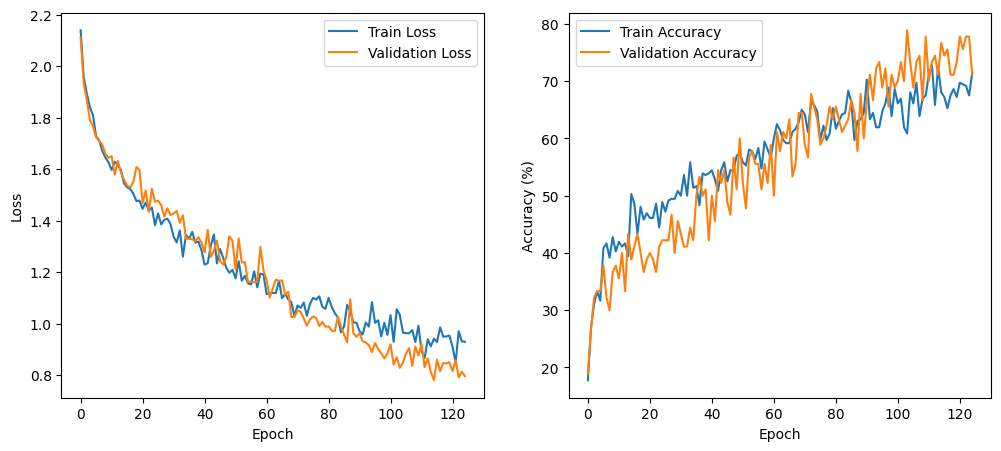

C:\Users\heman\AppData\Local\Temp\ipykernel_38984\3810554107.py:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gnn_model.pth"))


Test Accuracy: 33.33%

Per-class accuracy:
aphids: 24.00% (12/50)
armyworm: 32.00% (16/50)
beetle: 46.00% (23/50)
bollworm: 46.00% (23/50)
grasshopper: 24.00% (12/50)
mites: 28.00% (14/50)
mosquito: 52.00% (26/50)
sawfly: 24.00% (12/50)
stem_borer: 24.00% (12/50)


In [15]:
# Execute training
if __name__ == "__main__":
    train_dir = 'Dataset/pest/train'
    test_dir = 'Dataset/pest/test'
    
    model, test_acc = train_gnn_model(train_dir, test_dir)